(400, 600, 3)


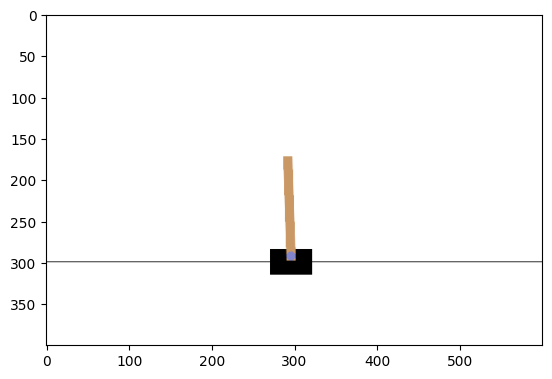

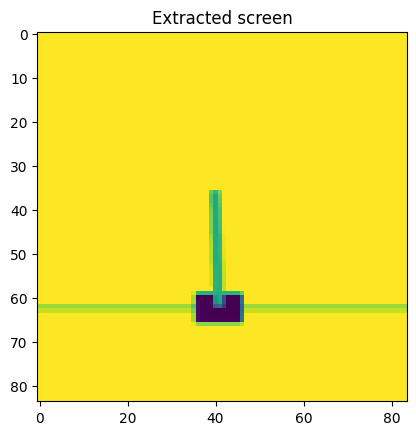

In [49]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
IMAGE_SIZE = 84

# Screen scraping

resize = T.Compose([T.ToPILImage(), T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.BICUBIC), T.ToTensor()])

def get_human_screen(render_frame):
    return Image.fromarray(render_frame)

def get_torch_screen(render_frame):
    # Grayscale and resize the screen to 84x84
    p_img = Image.fromarray(render_frame)
    p_img = ImageOps.grayscale(p_img)
    p_img = ImageOps.fit(p_img, [IMAGE_SIZE, IMAGE_SIZE])
    
    img_array = np.ascontiguousarray(p_img, dtype=np.float32) / 255
    torch_screen = torch.from_numpy(img_array)
    return resize(torch_screen).to(device)

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

env.reset()
frame = env.render()
print(frame.shape)

plt.figure()
plt.imshow(get_human_screen(frame))

plt.figure()
plt.imshow(get_torch_screen(frame).cpu().permute(1, 2, 0).numpy(), interpolation='nearest')

plt.title('Extracted screen')
plt.show()

In [50]:
# Memory

Transition = namedtuple('Transition', ['state', 'action', 'next_state', 'reward'])

class Memory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
            
    def sample(self, batch_size):
        if batch_size > len(self.memory):
            return random.sample(self.memory, len(self.memory))
        else:
            return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    
# Model

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        return self.head(x.view(x.size(0), -1))

RuntimeError: shape '[1, 1]' is invalid for input of size 4

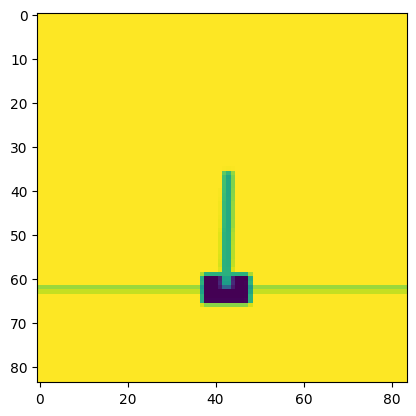

In [54]:
# Training
init_screen = get_screen()
_, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = Memory(10000)

steps_done = 0
episode_durations = []

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done +=1
    
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    
# Main training loop
num_episodes = 50
screen_buffer = []
for ie in range(num_episodes):
    env.reset()
    frame = env.render()
    
    for i in range(4):
        screen_buffer.append(get_torch_screen(frame))
        
    
    state = torch.stack(screen_buffer).to(device)
    
    for t in count():
        # print(t, state.shape)
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        if done:
            next_state = None
        else:
            _, *screen_buffer = screen_buffer
            frame = env.render()
            screen_buffer.append(get_torch_screen(frame))
            next_state = torch.stack(screen_buffer).to(device)
            
        if t == 4:
            plt.imshow(sum(screen_buffer).cpu().squeeze(0).numpy(), interpolation='none')
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
            
        if ie % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

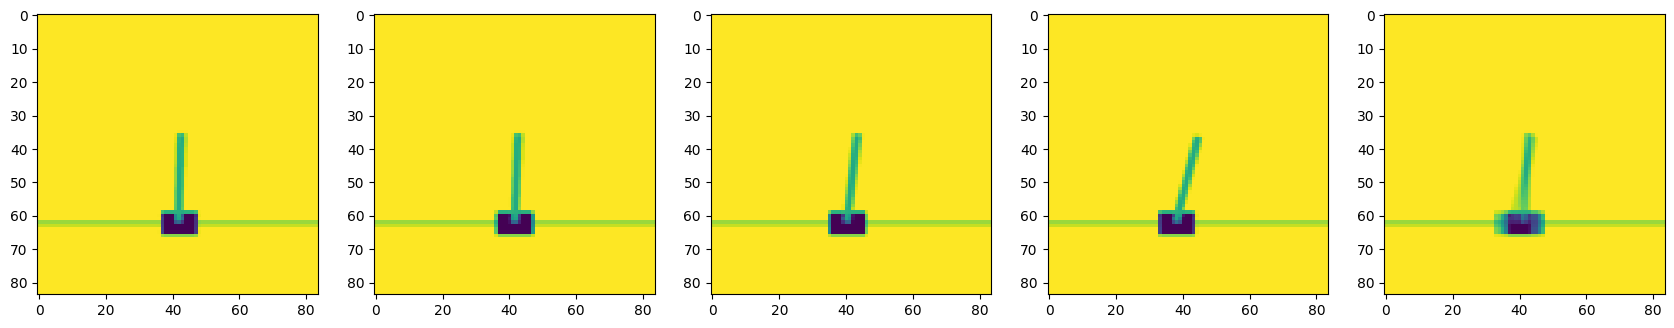

In [63]:

env.reset()

screens = []
screens.append(get_torch_screen(env.render()).cpu().squeeze(0).numpy())

for _ in range(0, 3):
    env.step(0)
screens.append(get_torch_screen(env.render()).cpu().squeeze(0).numpy())

for _ in range(0, 3):
    env.step(0)
screens.append(get_torch_screen(env.render()).cpu().squeeze(0).numpy())

for _ in range(0, 3):
    env.step(0)
screens.append(get_torch_screen(env.render()).cpu().squeeze(0).numpy())

#screens = [
#    get_screen().cpu().squeeze(0).numpy(), 
#    get_screen().cpu().squeeze(0).numpy(),
#    get_screen().cpu().squeeze(0).numpy(), 
#    get_screen().cpu().squeeze(0).numpy()
#]

f, grid = plt.subplots(1,5, figsize=(21, 21))
for ax, im in zip(grid, screens + [np.add.reduce(screens)]):
    ax.imshow(im)

env.close()
plt.ioff()
plt.show()

In [ ]:
a = [1, 1, 0, 0]
b = [0, 0, 1, 1]
c = [0, 1, 1, 0]
x = [a, b, c]
np.add.reduce(x)

In [ ]:
torch.tensor([1, 1, 0, 0]) + torch.tensor([0, 0, 1, 1]) + torch.tensor([0, 1, 1, 0])

In [ ]:
a = torch.tensor([1, 1, 0, 0]) 
b = torch.tensor([0, 0, 1, 1]) 
c = torch.tensor([0, 1, 1, 0])
d = torch.tensor([0, 1, 1, 1])
x = torch.stack([a, b, c, d])
torch.sum(x, 0)